In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [3]:
data = pd.read_csv('sakura_final_df.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Location                 1972 non-null   object 
 1   Observation_Status       1972 non-null   object 
 2   year                     1972 non-null   int64  
 3   peak_bloom_date          1972 non-null   object 
 4   bloom_day_of_year        1972 non-null   float64
 5   lat                      1972 non-null   float64
 6   long                     1972 non-null   float64
 7   Average temperature (℃)  1972 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 123.4+ KB


In [4]:
data.drop(columns=['Observation_Status'], inplace = True)

In [5]:
data.head()

,Location,year,peak_bloom_date,bloom_day_of_year,lat,long,Average temperature (℃)
0,Abashiri,1991,1991-05-08,128.0,44.017778,144.279722,13.7
1,Abashiri,1992,1992-05-13,134.0,44.017778,144.279722,11.8
2,Abashiri,1993,1993-05-20,140.0,44.017778,144.279722,8.5
3,Abashiri,1994,1994-05-13,133.0,44.017778,144.279722,7.3
4,Abashiri,1995,1995-05-08,128.0,44.017778,144.279722,11.1


## Time series stat tests

before we continue with our feature engineering lets check for some time series properties, such as stationarity and seasonality.

For seasonality analysis our data consists of one observation per year (e.g., peak bloom day of the year) over multiple years, and so our series will not necessarily be tested for intra-year seasonality (within the same year) but rather we will test if our series may show inter-year trends or patterns (between different years). In this case, traditional seasonality detection methods that rely on high-frequency data (like daily or monthly observations) are not fully applicable. And so, we will try and check for year-over-year patterns, and so the interpretation will be more about long-term trends rather than seasonality in the 'traditional sense'.

In [21]:
def check_variance(series, location):
    variance = np.var(series) # check the variance of the series itself
    
    print(f"Location: {location}")
    print(f"Variance: {variance}")
    
    if variance > 10:  # The threshold here is arbitrary
        print("Result: Variability detected (possibly indicating patterns)\n")
    else:
        print("Result: Low variability (no significant patterns detected)\n")

for location, group in data.groupby('Location'):
    check_variance(group['bloom_day_of_year'], location)

Location: Abashiri
Variance: 57.29757785467131
Result: Variability detected (possibly indicating patterns)

Location: Akita
Variance: 30.9688581314879
Result: Variability detected (possibly indicating patterns)

Location: Aomori
Variance: 33.18771626297579
Result: Variability detected (possibly indicating patterns)

Location: Asahikawa
Variance: 36.85467128027682
Result: Variability detected (possibly indicating patterns)

Location: Choshi
Variance: 23.471453287197225
Result: Variability detected (possibly indicating patterns)

Location: Fukui
Variance: 24.761245674740476
Result: Variability detected (possibly indicating patterns)

Location: Fukuoka
Variance: 22.301038062283734
Result: Variability detected (possibly indicating patterns)

Location: Fukushima
Variance: 31.139273356401386
Result: Variability detected (possibly indicating patterns)

Location: Gifu
Variance: 21.61937716262976
Result: Variability detected (possibly indicating patterns)

Location: Hakodate
Variance: 29.575259

And as expected our data for all the locations shows strong variability, which could be an indicator for seasonal trends. This is no surprise since we are studying a natural phenomeon that is heavily dependant on consistent, recurring factors (such as temperature, climate conditions, and  geographical characteristics). This regularity is a good sign, as it can improve the accuracy of our forecasting models.

In [10]:
# Stationarity Test

# using ADF test
def adf_test(series, location):
    result = adfuller(series.dropna())  # Drop NA values for the test even though we know we don't have missing data but just in case
    print(f"Location: {location}")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}\n")

    # Determine if the series is stationary
    if result[1] < 0.05:
        print("Result: The series is stationary\n")
    else:
        print("Result: The series is non-stationary\n")

# Group by location and apply ADF test
for location, group in data.groupby('Location'):
    adf_test(group['bloom_day_of_year'], location)

Location: Abashiri
ADF Statistic: -4.200338315314873
p-value: 0.0006580318866234545

Result: The series is stationary

Location: Akita
ADF Statistic: -3.173739259076903
p-value: 0.02155596952773351

Result: The series is stationary

Location: Aomori
ADF Statistic: -3.134854060890716
p-value: 0.024079067893493032

Result: The series is stationary

Location: Asahikawa
ADF Statistic: -3.9917125486644567
p-value: 0.0014545339184398411

Result: The series is stationary

Location: Choshi
ADF Statistic: -5.101307161361162
p-value: 1.3934397333286076e-05

Result: The series is stationary

Location: Fukui
ADF Statistic: -4.884006813004282
p-value: 3.7462303829531156e-05

Result: The series is stationary

Location: Fukuoka
ADF Statistic: -5.050593573926241
p-value: 1.7606774830905485e-05

Result: The series is stationary

Location: Fukushima
ADF Statistic: -0.35517045699954025
p-value: 0.9173189407997151

Result: The series is non-stationary

Location: Gifu
ADF Statistic: -4.76794854558366
p-val

Looking at the resulting p-values of the test we came to the conclusion that most of our series are stationary, this means that the properties of the series remain consistent throughout time.  analysis.

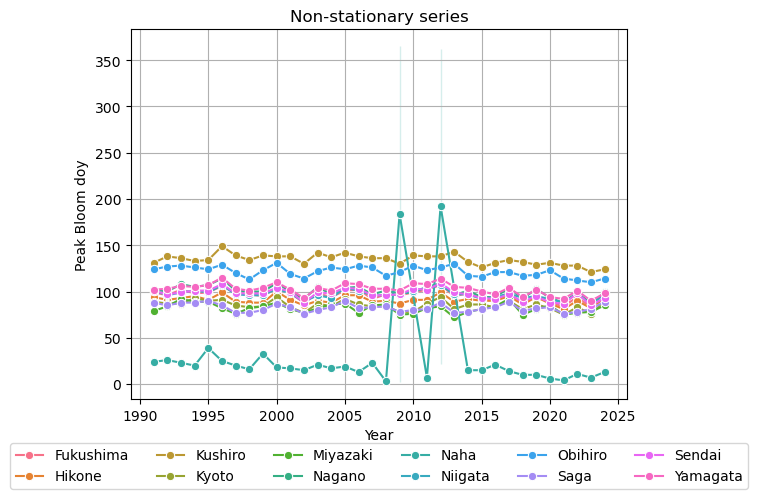

In [17]:
# lest plot the non-stationary data 

non_station_loc = ['Fukushima', 'Hikone', 'Kushiro', 'Kyoto', 'Miyazaki', 'Nagano', 'Naha', 'Niigata', 'Obihiro', 'Saga', 'Sendai', 'Yamagata']

sns.lineplot(data=data.loc[data['Location'].isin(non_station_loc)], x='year', y='bloom_day_of_year', hue='Location', marker='o')
plt.title('Non-stationary series')
plt.xlabel('Year')
plt.ylabel('Peak Bloom doy')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)
plt.grid(True)
plt.margins(x=0.05, y=0.05)
plt.show()

we will do our train, split test earlier to prevent any data leakage -> perform all feature engineering, after the data is split. This way, the model only uses information that would have been available at the time of prediction

## train-test split

In [6]:
# we will do it now to avoid data leackage
train = data[data['year'] <= 2018]  # Training on data up to year 2020
test = data[data['year'] > 2018]

## Additional feature engineering

In [7]:
# Extracting month and day from peak_bloom_date
#train['month'] = pd.to_datetime(train['peak_bloom_date']).dt.month
#train['day'] = pd.to_datetime(train['peak_bloom_date']).dt.day

#test['month'] = pd.to_datetime(test['peak_bloom_date']).dt.month
#test['day'] = pd.to_datetime(test['peak_bloom_date']).dt.day

train.drop(columns=['peak_bloom_date'], inplace=True)
test.drop(columns=['peak_bloom_date'], inplace=True)

train.head()

,Location,year,bloom_day_of_year,lat,long,Average temperature (℃)
0,Abashiri,1991,128.0,44.017778,144.279722,13.7
1,Abashiri,1992,134.0,44.017778,144.279722,11.8
2,Abashiri,1993,140.0,44.017778,144.279722,8.5
3,Abashiri,1994,133.0,44.017778,144.279722,7.3
4,Abashiri,1995,128.0,44.017778,144.279722,11.1


### Lagged Features:

Since we decided to use Machine Learnng regression techniques for our forecasting approach, lagged features are a good addition to our data and are a way to compensate for the possible lost information about the effects of the past observations on the current ones. In other words, we will try and capture the temporal dependencies and use previous years' blooming dates as predictors for future years.

lagged data is important, but the number to choose is a bit tricky to define. We want to define a few to capture the effect of previous years but at the same time not too many to not risk overfitting. if we go back we can see that the trend for average blooming dates has been drastically changing in the past 10 years so we have to account for that without overfitting our model, so we will start with a relatively small number and test our model performance, if needs call for it we will add or reduce the lag variables

In [8]:
# Create lagged feature: previous 3 year's bloom day

def add_lagged_features(df, max_lag):
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df.groupby('Location')['bloom_day_of_year'].shift(lag)
    return df

# For now we are starting with 3
train_with_lags = add_lagged_features(train.copy(), max_lag=3)
test_with_lags = add_lagged_features(test.copy(), max_lag=3)

In [9]:
# since the lag variables will introduce some missing values and we can not afford to drop observations, we will impute the values with mean calculated for each location separately

# Impute missing values in lagged features with mean by location
def impute_lagged_features_with_mean(df):
    lag_columns = [col for col in df.columns if col.startswith('lag_')]
    for col in lag_columns:
        means = df.groupby('Location')[col].transform('mean')
        df[col] = df[col].fillna(means)
    return df


train_with_lags = impute_lagged_features_with_mean(train_with_lags)
test_with_lags = impute_lagged_features_with_mean(test_with_lags)

In [11]:
# now that we don't need to use the Location column anymore lets encode it 

train_processed = pd.get_dummies(train_with_lags, columns=['Location'])
test_processed = pd.get_dummies(test_with_lags, columns=['Location'])

## Model training

As we mentioned earlier, our model choice was based off of the model’s ability to capture and correctly handle our time series properties. With that in mind we choose three common examples of machine learning models used in this scenario, namely two ensemble methods Gradient Boosting Machines (GBM), and Random Forest, as well as a Recurrent Neural Networks variant LSTM (Long Short-Term Memory).

At this point in the analysis, we also chose to train our models on all locations combined (multiple series), we can only hope that the model accurately captures the slight differences between locations, training different models on different locations will be too computationally expensive, and would require much more data. 

In [29]:
X_train = train_processed.drop(columns=['bloom_day_of_year'])
y_train = train_processed['bloom_day_of_year']
X_test = train_processed.drop(columns=['bloom_day_of_year'])
y_test = train_processed['bloom_day_of_year']

In [47]:
def plot_predictions_vs_actual(y_true, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, color='b')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name} - Predictions vs Actual')
    plt.tight_layout()
    plt.show()

### Randon Forest

In [31]:
# Random forest

rf_param_grid = {
    'n_estimators': [100, 200, 300, 500],           
    'max_depth': [10, 20, 30, None],                
    'min_samples_split': [2, 5, 10],                
    'min_samples_leaf': [1, 2, 4],                  
    'max_features': ['auto', 'sqrt', 'log2']        
}

# Initialize models
rf_model = RandomForestRegressor()

rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, 
                                scoring='r2', cv=5, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


C:\Users\acer\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
411 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\acer\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\acer\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\acer\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\acer\anaconda3\Lib\site-packages\s

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 500]},
             scoring='r2', verbose=2)

In [32]:
print(f"Best parameters for Random Forest: {rf_grid_search.best_params_}")
print(f"Best R2 for Random Forest: {rf_grid_search.best_score_}")

Best parameters for Random Forest: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Best MSE for Random Forest: 0.733552600693389


In [93]:
# Train final models with the entire training set
rf_model_final = RandomForestRegressor(max_depth = None, 
                                       max_features = 'log2', 
                                       min_samples_leaf = 4, 
                                       min_samples_split = 5, 
                                       n_estimators = 100)
rf_model_final.fit(X_train, y_train)

RandomForestRegressor(max_features='log2', min_samples_leaf=4,
                      min_samples_split=5)

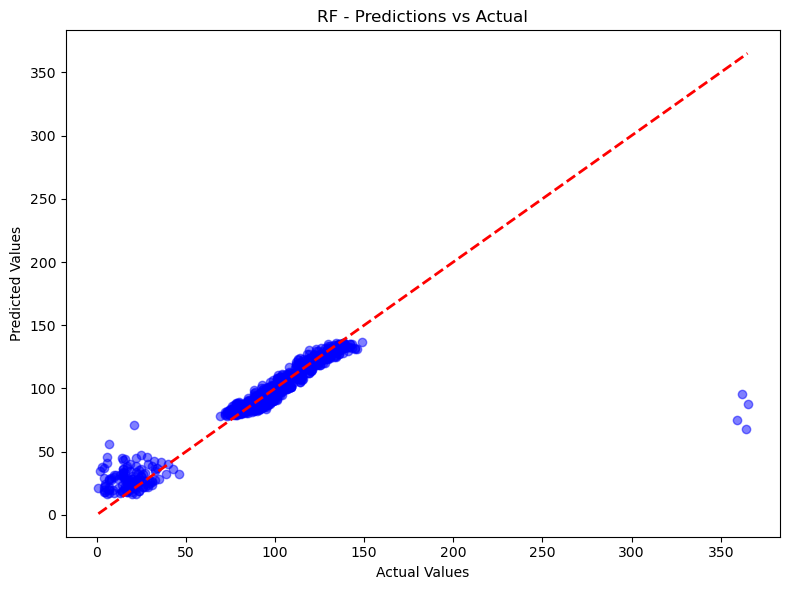

In [94]:
rf_predictions_final = rf_model_final.predict(X_test)
plot_predictions_vs_actual(y_test, rf_predictions_final, 'RF')

### XGBoost

In [40]:
# XGBoost

xgb_param_grid = {
    'n_estimators': [100, 200, 300],                 
    'max_depth': [3, 5, 7, 10],                          
    'learning_rate': [0.01, 0.05, 0.1],                                          
    'gamma': [0, 0.1, 0.3, 0.5],                         
    'min_child_weight': [1, 3, 5, 7]                     
}

# Initialize models
xgb_model = xgb.XGBRegressor()

xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, 
                                scoring='r2', cv=5, n_jobs=-1, verbose=2)
xgb_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.3, 0.5],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7, 10],
                         'min_child_weight': [1, 3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='r2', verbose=2)

In [50]:
print(f"Best parameters for XGBoost: {xgb_grid_search.best_params_}")
print(f"Best R2 for XGBoost: {xgb_grid_search.best_score_}")

Best parameters for XGBoost: {'gamma': 0.3, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 7, 'n_estimators': 300}
Best R2 for XGBoost: 0.70623798608486


In [91]:
# Train final models with the entire training set
xgb_model_final = xgb.XGBRegressor(n_estimators=300, 
                                   max_depth=10, 
                                   learning_rate=0.01,
                                   gamma = 0.3,
                                   min_child_weight = 7
                                  )
xgb_model_final.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

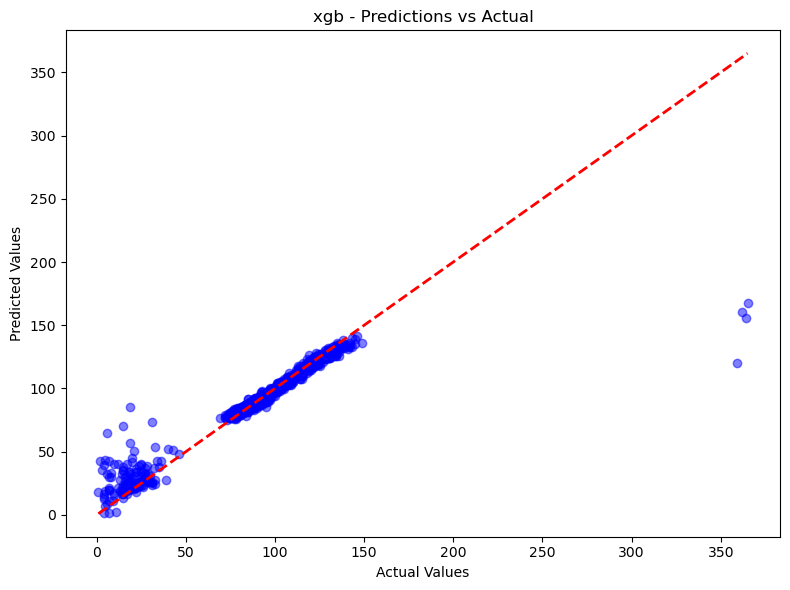

In [92]:
xgb_predictions_final = xgb_model_final.predict(X_test)
plot_predictions_vs_actual(y_test, xgb_predictions_final, 'xgb')

### LSTM

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [161]:
# LSTM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler_y = StandardScaler() 
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [57]:
# Reshape data to fit LSTM input (samples, time_steps, features)
time_steps = 1  # If using lag features, set the appropriate number of time steps #check this again bcz we typically just used the default
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], time_steps, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], time_steps, X_test_scaled.shape[1]))

In [ ]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(1, X_train_reshaped.shape[2])))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_reshaped, y_train_scaled, epochs=50, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled))

In [59]:
y_pred_scaled = model.predict(X_test_reshaped)

# Inverse transform the predictions
y_pred = scaler_y.inverse_transform(y_pred_scaled)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [61]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)

print(f"R² Score: {r2}")

R² Score: 0.7133434561174203


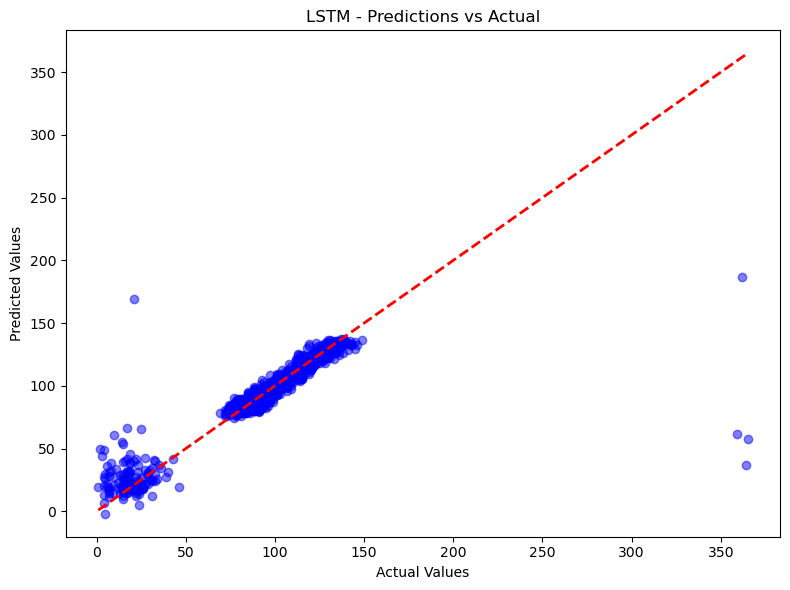

In [63]:
plot_predictions_vs_actual(y_test, y_pred, 'LSTM')

## Forecasting

In [127]:
# Since its a bit tricky to get access to the forecasts of temperatures for 2025 across all locations (especially since the blooming times vary across locations)
# we instead use the avg temperatures across our historical data and use it for our foecasting
mean_temperature_per_location = data.groupby('Location')['Average temperature (℃)'].mean().reset_index()
mean_temperature_per_location.columns = ['Location', 'Average temperature (℃)']

In [128]:
locations = data['Location'].unique()

# Create a DataFrame for 2025
data_2025 = pd.DataFrame({
    'Location': locations,
    'year': 2025
})

In [129]:
# Merge with mean temperatures
data_2025 = data_2025.merge(mean_temperature_per_location, on='Location')

In [130]:
# Get lat and long from historical data
data_2025 = data_2025.merge(data[['Location', 'lat', 'long']].drop_duplicates(), on='Location')

In [131]:
data_2025.head(10)

,Location,year,Average temperature (℃),lat,long
0,Abashiri,2025,10.611765,44.017778,144.279722
1,Akita,2025,10.500000,39.717500,140.099167
2,Aomori,2025,10.885294,40.821667,140.768889
3,Asahikawa,2025,13.008824,43.756944,142.372222
4,Choshi,2025,12.426471,35.739722,140.857222
5,Fukui,2025,11.800000,36.055556,136.222500
6,Fukuoka,2025,13.005882,33.582222,130.376389
7,Fukushima,2025,11.397059,37.759444,140.470833
8,Gifu,2025,11.229412,35.400278,136.762500
9,Hakodate,2025,10.705882,41.816667,140.754167


In [132]:
# addng the lags now would be a bit tricky 

data_2025['lag_1'] = None
data_2025['lag_2'] = None
data_2025['lag_3'] = None

# Loop through each location and assign lag values
for index, row in data_2025.iterrows():
    location = row['Location']
    
    # Filter relevant data from test_with_lags for the current location
    location_data = test_with_lags[test_with_lags['Location'] == location]
    # Get the last 3 years of data
    lags = location_data[['lag_1', 'lag_2', 'lag_3']].iloc[-1].values
    data_2025.loc[index, ['lag_1', 'lag_2', 'lag_3']] = lags

data_2025[['lag_1', 'lag_2', 'lag_3']] = data_2025[['lag_1', 'lag_2', 'lag_3']].apply(pd.to_numeric, errors='coerce')

In [133]:
data_2025.head()

,Location,year,Average temperature (℃),lat,long,lag_1,lag_2,lag_3
0,Abashiri,2025,10.611765,44.017778,144.279722,118.0,117.0,126.0
1,Akita,2025,10.500000,39.717500,140.099167,94.0,102.0,94.0
2,Aomori,2025,10.885294,40.821667,140.768889,97.0,106.0,103.0
3,Asahikawa,2025,13.008824,43.756944,142.372222,115.0,116.0,119.0
4,Choshi,2025,12.426471,35.739722,140.857222,81.0,86.0,81.0


In [134]:
#before we continue lets reorder the columns to match our training data
data_2025 = data_2025[['Location','year', 'lat', 'long', 'Average temperature (℃)', 'lag_1', 'lag_2', 'lag_3']]

In [135]:
data_2025.head()

,Location,year,lat,long,Average temperature (℃),lag_1,lag_2,lag_3
0,Abashiri,2025,44.017778,144.279722,10.611765,118.0,117.0,126.0
1,Akita,2025,39.717500,140.099167,10.500000,94.0,102.0,94.0
2,Aomori,2025,40.821667,140.768889,10.885294,97.0,106.0,103.0
3,Asahikawa,2025,43.756944,142.372222,13.008824,115.0,116.0,119.0
4,Choshi,2025,35.739722,140.857222,12.426471,81.0,86.0,81.0


In [136]:
data_2025_processed = pd.get_dummies(data_2025, columns=['Location'])

In [163]:
data_2025_scaled = scaler.transform(data_2025_processed) # for LSTM
data_2025_lstm = data_2025_scaled.reshape((data_2025_scaled.shape[0], 1, data_2025_scaled.shape[1]))

In [169]:
data_2025['RF_Bloom_Day'] = rf_model_final.predict(data_2025_processed)
data_2025['XGB_Bloom_Day'] = xgb_model_final.predict(data_2025_processed)

lstm_pred = model.predict(data_2025_lstm)
lstm_pred_inverse = scaler_y.inverse_transform(lstm_pred)
data_2025['LSTM_Bloom_Day'] = lstm_pred_inverse

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [170]:
data_2025[['Location', 'RF_Bloom_Day', 'XGB_Bloom_Day', 'LSTM_Bloom_Day']]

,Location,RF_Bloom_Day,XGB_Bloom_Day,LSTM_Bloom_Day
0,Abashiri,124.672316,121.794823,125.756966
1,Akita,100.002796,103.295952,109.295151
2,Aomori,106.105524,106.761406,108.811447
3,Asahikawa,121.934616,117.081894,125.687401
4,Choshi,87.470741,83.211075,88.553009
5,Fukui,87.011065,83.892136,89.610649
6,Fukuoka,80.309863,81.245911,82.423256
7,Fukushima,92.101645,92.251076,93.243523
8,Gifu,84.076826,80.961037,81.798439
9,Hakodate,113.473713,112.385597,117.474091


In [172]:
# convert day of year to actual blooming date
def day_of_year_to_date(year, day_of_year):
    return datetime(year, 1, 1) + timedelta(days=day_of_year - 1)

data_2025['RF_Bloom_Date'] = data_2025['RF_Bloom_Day'].apply(lambda x: day_of_year_to_date(2025, x).strftime('%Y-%m-%d'))
data_2025['XGB_Bloom_Date'] = data_2025['XGB_Bloom_Day'].apply(lambda x: day_of_year_to_date(2025, x).strftime('%Y-%m-%d'))
data_2025['LSTM_Bloom_Date'] = data_2025['LSTM_Bloom_Day'].apply(lambda x: day_of_year_to_date(2025, x).strftime('%Y-%m-%d'))

In [173]:
data_2025[['Location', 'RF_Bloom_Date', 'XGB_Bloom_Date', 'LSTM_Bloom_Date']]

,Location,RF_Bloom_Date,XGB_Bloom_Date,LSTM_Bloom_Date
0,Abashiri,2025-05-04,2025-05-01,2025-05-05
1,Akita,2025-04-10,2025-04-13,2025-04-19
2,Aomori,2025-04-16,2025-04-16,2025-04-18
3,Asahikawa,2025-05-01,2025-04-27,2025-05-05
4,Choshi,2025-03-28,2025-03-24,2025-03-29
5,Fukui,2025-03-28,2025-03-24,2025-03-30
6,Fukuoka,2025-03-21,2025-03-22,2025-03-23
7,Fukushima,2025-04-02,2025-04-02,2025-04-03
8,Gifu,2025-03-25,2025-03-21,2025-03-22
9,Hakodate,2025-04-23,2025-04-22,2025-04-27
